# Peptide Detectability Prediction 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/).

One of the example datasets used in this notebook is deposited in the ProteomeXchange Consortium via the MAssIVE partner repository with the identifier PXD024364. The other dataset is deposited to the ProteomeXchange Consortium via the PRIDE partner repository with identifier PXD010154. 

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

#### Installing the DLOmix Package

If you have not installed the DLOmix package yet, you need to do so before running the code. 

You can install the DLOmix package using pip.

In [1]:
# # install the DLOmix package in the current environment using pip

# !python -m pip install git+https://github.com/wilhelm-lab/dlomix.git@feature/detectability-integration-hf-updates

#### Importing Required Libraries

Before running the code, ensure you import all the necessary libraries. These imports are essential for accessing the functionalities needed for data processing, model training, and evaluation.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import dlomix
import sys
import os
print([x for x in dir(dlomix) if not x.startswith("_")])

['META_DATA']


## Model

We can now create the model. The model architecture is an encoder-decoder with an attention mechanism, that is based on Bidirectional Recurrent Neural Network (BRNN) with Gated Recurrent Units (GRU). Both the Encoder and Decoder consists of a single layer, with the Decoder also including a Dense layer. The model has the default working arguments.

In [3]:
from dlomix.models import DetectabilityModel
from dlomix.constants import CLASSES_LABELS, alphabet, aa_to_int_dict

C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [4]:
CLASSES_LABELS, len(alphabet), aa_to_int_dict

(['Non-Flyer', 'Weak Flyer', 'Intermediate Flyer', 'Strong Flyer'],
 21,
 {'0': 0,
  'A': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'K': 9,
  'L': 10,
  'M': 11,
  'N': 12,
  'P': 13,
  'Q': 14,
  'R': 15,
  'S': 16,
  'T': 17,
  'V': 18,
  'W': 19,
  'Y': 20})

In [5]:
total_num_classes = len(CLASSES_LABELS)
input_dimension = len(alphabet)
num_cells = 64

model = DetectabilityModel(num_units = num_cells, num_clases = total_num_classes)

#### Model Weights Configuration

In the following section, you need to specify the path to the model weights you wish to use. The default path provided is set to the weights for the **Pfly** model, which is the fine-tuned model mentioned in the publication associated with this notebook.

- **Using the Default Pfly Model**: If you are utilizing the fine-tuned Pfly model as described in the publication, you can keep the default path unchanged. This will load the model weights for Pfly.

- **Using the Base Model or Different Weights**: If you intend to use the base model or have different weights (e.g., for a custom model), you should update the path to reflect the location of these weights.

In [6]:
## Loading model's weights 

# model_save_path = 'pretrained_models/original_detectability_fine_tuned_model/original_detectability_fine_tuned_model'
model_save_path =  'DETECTABILITY MODEL CODE/fine_tuned_attention_weights_FINAL_clean_NON/fine_tuned_weights_attention_model_FINAL_NON'

model.load_weights(model_save_path)

## Workflow Overview

This notebook supports two different workflows depending on your dataset:

- **Labeled Data**: Use this pipeline when your dataset includes ground truth labels. This setup not only makes predictions but also allows for detailed evaluation by comparing the true labels with the predicted values, facilitating the generation of a comprehensive evaluation report.

- **Unlabeled Data**: Use this pipeline when your dataset does not include labels. Here, the focus is on making predictions only, without generating a detailed performance report, as there are no labels to compare against.

### Notebook Structure

Subtitles throughout the notebook indicate the sections for each type of data:

- **Labeled Data Section**: Follow these when your dataset includes labels to receive predictions and a comprehensive evaluation report.

- **Unlabeled Data Section**: Use these when your dataset lacks labels, focusing solely on generating predictions.

Make sure to select the appropriate pipeline based on your dataset.

# Labeled Data

## 1. Load Data 

You can import the `DetectabilityDataset` class and create an instance to manage data for training, validation, and testing. This instance handles TensorFlow dataset objects and simplifies configuring and controlling how your data is split.

#### Parameters

- **data_source** (`Optional[Union[str, List]]`): The path or list of paths to the data source file(s). Defaults to `None`.
  
- **val_data_source** (`Optional[Union[str, List]]`): The path or list of paths to the validation data source file(s). Defaults to `None`.

- **test_data_source** (`Optional[Union[str, List]]`): The path or list of paths to the test data source file(s). Defaults to `None`.

- **data_format** (`str`): The format of the data source file(s). Defaults to `"parquet"`.

- **sequence_column** (`str`): The name of the column containing the peptide sequences. Defaults to `"Sequences"`.

- **label_column** (`str`): The name of the column containing the class labels. Defaults to `"Classes"`.

- **val_ratio** (`float`): The ratio of validation data to split from the training data. Defaults to `0.2`.

- **max_seq_len** (`Union[int, str]`): The maximum length of the peptide sequences. Defaults to `30`.

- **dataset_type** (`str`): The type of dataset to use. Defaults to `"tf"`.

- **batch_size** (`int`): The batch size for training and evaluation. Defaults to `256`.

- **model_features** (`Optional[List[str]]`): The list of features to use for the model. Defaults to `None`.

- **dataset_columns_to_keep** (`Optional[List[str]]`): The list of columns to keep in the dataset. Defaults to `["Proteins"]`.

- **features_to_extract** (`Optional[List[Union[Callable, str]]]`): The list of features to extract from the dataset. Defaults to `None`.

- **pad** (`bool`): Whether to pad the sequences to the maximum length. Defaults to `True`.

- **padding_value** (`int`): The value to use for padding. Defaults to `0`.

- **alphabet** (`Dict`): The mapping of characters to integers for encoding the sequences. Defaults to `ALPHABET_UNMOD`.

- **with_termini** (`bool`): Whether to add the N- and C-termini in the sequence column, even if they do not exist. Defaults to `True`.

- **encoding_scheme** (`Union[str, EncodingScheme]`): The encoding scheme to use for encoding the sequences. Defaults to `EncodingScheme.UNMOD`.

- **processed** (`bool`): Whether the data has been preprocessed. Defaults to `False`.

- **enable_tf_dataset_cache** (`bool`): Flag to indicate whether to enable TensorFlow Dataset caching (call `.cache()` on the generated TF Datasets). Defaults to `False`.

- **disable_cache** (`bool`): Whether to disable Hugging Face datasets caching. Defaults to `False`.


**Note**: If class labels are provided, the following encoding scheme should be used:
- **Non-Flyer**: 0
- **Weak Flyer**: 1
- **Intermediate Flyer**: 2
- **Strong Flyer**: 3

In [7]:
from dlomix.data import DetectabilityDataset

In [8]:
# Sinitcyn_test_data = '../example_dataset/Sinitcyn_test_dataset.csv'
# Wang_test_data = '../example_dataset/Wang_test_dataset.csv'

Sinitcyn_test_data = 'Sinitcyn_test_dataset.csv'
Wang_test_data = 'Wang_test_dataset.csv'

max_pep_length = 40
BATCH_SIZE = 128
     
    
detectability_data = DetectabilityDataset(data_source=None,
                                          val_data_source=None,
                                          test_data_source=Sinitcyn_test_data,
                                          data_format='csv',
                                          max_seq_len=max_pep_length,
                                          label_column="Classes",
                                          sequence_column="Sequences",
                                          dataset_columns_to_keep=['Proteins'],
                                          batch_size=BATCH_SIZE,
                                          with_termini=False,
                                          alphabet=aa_to_int_dict,
                                          auto_cleanup_cache=False)


Applying step: SequenceParsingProcessor on split test...
Applying step: SequencePTMRemovalProcessor on split test...
Applying step: SequenceEncodingProcessor on split test...
Applying step: SequencePaddingProcessor on split test...


C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\dlomix\data\dataset.py:380: UserWarning: Encoding scheme is unmod, this enforces removing all occurences of PTMs in the sequences.
If you prefer to encode the (amino-acids)+PTM combinations as tokens in the vocabulary, please use the encoding scheme 'naive-mods'.

  warnings.warn(


In [9]:
# This is the dataset with the test split  
# You can see the column names under each split (the columns starting with _ are internal, but can also be used to look up original sequences for example "_parsed_sequence")
detectability_data

DatasetDict({
    test: Dataset({
        features: ['Sequences', 'Classes', 'Proteins', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 60185
    })
})

In [10]:
# Accessing elements in the dataset is done by specificing the split name and then the column name
# Example here for one sequence after encoding & padding comapred to the original sequence

detectability_data["test"]["Sequences"][0], "".join(detectability_data["test"]["_parsed_sequence"][0])

([17,
  12,
  14,
  10,
  4,
  1,
  8,
  12,
  1,
  1,
  10,
  10,
  6,
  4,
  3,
  2,
  5,
  8,
  10,
  11,
  13,
  17,
  6,
  6,
  6,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'TNQLEAINAALLGEDCFILMPTGGGK')

## 2. Testing and Reporting

We use the test dataset to assess our model's performance, which is only applicable if labels are available. The `DetectabilityReport` class allows us to compute various metrics, generate reports, and create plots for a comprehensive evaluation of the model.

Note: The reporting module is currently under development, so some features may be unstable or subject to change.

##### Generate Predictions on Test Data Using `model.predict`

To obtain predictions for your test data, use the Keras `model.predict` method. Simply pass your test dataset to this method, and it will return the model's predictions.

In [11]:
predictions = model.predict(detectability_data.tensor_test_data)

C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\datasets\arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


471/471 [==============================] - 10s 8ms/step


In [12]:
predictions.shape

(60185, 4)

To generate reports and calculate evaluation metrics against predictions, we obtain the targets and the data for the specific dataset split. This can be achieved using the `DetectabilityDataset` class directly.

In [13]:
# access val dataset and get the Classes column
test_targets = detectability_data["test"]["Classes"]


# if needed, the decoded version of the classes can be retrieved by looking up the class names
test_targets_decoded = [CLASSES_LABELS[x] for x in test_targets]


test_targets[0:5], test_targets_decoded[0:5]

([1, 3, 3, 0, 2],
 ['Weak Flyer',
  'Strong Flyer',
  'Strong Flyer',
  'Non-Flyer',
  'Intermediate Flyer'])

In [14]:
# The dataframe needed for the report

test_data_df = pd.DataFrame(
    {
        "Sequences": detectability_data["test"]["_parsed_sequence"], # get the raw parsed sequences
        "Classes": test_targets, # get the test targets from above
        "Proteins": detectability_data["test"]["Proteins"] # get the Proteins column from the dataset object
    }
)

test_data_df.Sequences = test_data_df.Sequences.apply(lambda x: "".join(x)) # join the sequences since they are a list of string amino acids.
test_data_df.head(5)

,Sequences,Classes,Proteins
0,TNQLEAINAALLGEDCFILMPTGGGK,1,P54132
1,QAYTSAPMVDNELLR,3,Q5T200
2,LTVENIGYQMLMK,3,Q8IWZ8
3,NFLFRPTSANMLQHPFVR,0,Q7Z2Y5
4,ICLDNDER,2,Q03188


In [15]:
from dlomix.reports.DetectabilityReport import DetectabilityReport, predictions_report
WANDB_REPORT_API_DISABLE_MESSAGE=True

#### Generate a Report Using the `DetectabilityReport` Class

The `DetectabilityReport` class provides a comprehensive way to evaluate your model by generating detailed reports and visualizations. The outputs include:

1. **A PDF Report**: This includes evaluation metrics and plots.
2. **A CSV File**: Contains the model’s predictions.
3. **Independent Image Files**: Visualizations are saved as separate image files.

To generate a report, provide the following parameters to the `DetectabilityReport` class:

- **targets**: The true labels for the dataset, which are used to assess the model’s performance.
- **predictions**: The model’s output predictions for the dataset, which will be compared against the true labels.
- **input_data_df**: The DataFrame containing the input data used for generating predictions.
- **output_path**: The directory path where the generated reports, images, and CSV file will be saved.
- **history**: The training history object (e.g., containing metrics from training) if available. Set this to `None` if not applicable, such as when the report is generated for predictions without training.
- **rank_by_prot**: A boolean indicating whether to rank peptides based on their associated proteins (`True` or `False`). Defaults to `False`.
- **threshold**: The classification threshold used to adjust the decision boundary for predictions. By default, this is set to `None`, meaning no specific threshold is applied.
- **name_of_dataset**: The name of the dataset used for generating predictions, which will be included in the report to provide context.
- **name_of_model**: The name of the model used to generate the predictions, which will be specified in the report for reference.

In [16]:
# Since the detectabiliy report expects the true labels in one-hot encoded format, we expand them here. Otherwise, the reporting class can be updated.

num_classes = np.max(test_targets) + 1
test_targets_one_hot = np.eye(num_classes)[test_targets] # THIS CAN BE CHANGED 
test_targets_one_hot.shape, len(test_targets)

((60185, 4), 60185)

In [17]:
report = DetectabilityReport(targets = test_targets_one_hot, 
                             predictions = predictions, 
                             input_data_df = test_data_df, 
                             output_path = "./output/report_on_Sinitcyn_2000_proteins_test_set_labeled", 
                             history = None, 
                             rank_by_prot = True,
                             threshold = None,
                             name_of_dataset = 'Sinitcyn 2000 proteins test set',
                             name_of_model = 'Fine-tuned model (Original)')

C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\dlomix\reports\Report.py:31: UserWarning: The passed History object is None, no training/validation data can be reported.
  warnings.warn(


Binary Accuracy: 0.79

Categorical Accuracy: 0.47

Matthews Correlation Coefficient (MCC): 0.5

True Positive Rate (Recall): 0.85

False Positive Rate (Specificity): 0.64

Precision: 0.83

F1 Score: 0.84


#### Predictions report

In [18]:
results_df = report.detectability_report_table
results_df

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions,Rank
0,ILFLVAAATGAHSQVQLVQSGSELK,A0A0J9YVY3,0.301,0.295,0.261,0.143,0.857,Intermediate Flyer,Weak Flyer,Flyer,Flyer,1
1,ASGYTFTSYAMNWVR,A0A0J9YVY3,0.307,0.214,0.206,0.274,0.727,Non-Flyer,Weak Flyer,Non-Flyer,Flyer,2
2,QAPGQGLEWMGWINTNTGNPTYAQGFTGR,A0A0J9YVY3,0.253,0.173,0.146,0.428,0.572,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,3
3,FVFSLDTSVSTAYLQICSLK,A0A0J9YVY3,0.174,0.038,0.001,0.786,0.213,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,4
4,KPGASVK,A0A0J9YVY3,0.004,0.000,0.000,0.996,0.004,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,5
...,...,...,...,...,...,...,...,...,...,...,...,...
60180,QLWMPFSVFDSLNLEEIYNSVQPDPESVVLGTDGGR,Q9Y6Y8,0.161,0.025,0.001,0.813,0.187,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,35
60181,AVAATSTK,Q9Y6Y8,0.104,0.027,0.003,0.866,0.134,Weak Flyer,Non-Flyer,Flyer,Non-Flyer,36
60182,IDYVLQEKPIESFNEYLFALQSHLCYWESEDTALLLLK,Q9Y6Y8,0.067,0.009,0.000,0.924,0.076,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,37
60183,GQEQSAQK,Q9Y6Y8,0.030,0.002,0.000,0.968,0.032,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,38


#### Generating Evaluation Plots with `DetectabilityReport`

The `DetectabilityReport` class enables you to generate a range of plots to visualize and evaluate model performance. It offers a comprehensive suite of visualizations to help you interpret the results of your model's predictions. Here’s how to use it:

##### ROC curve (Binary)

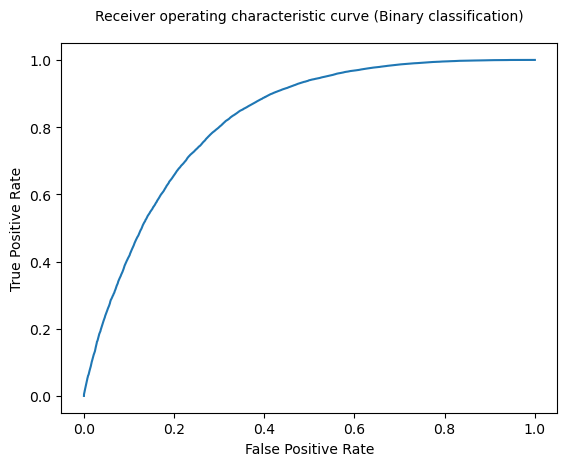

In [19]:
report.plot_roc_curve_binary()

##### Confusion matrix (Binary)

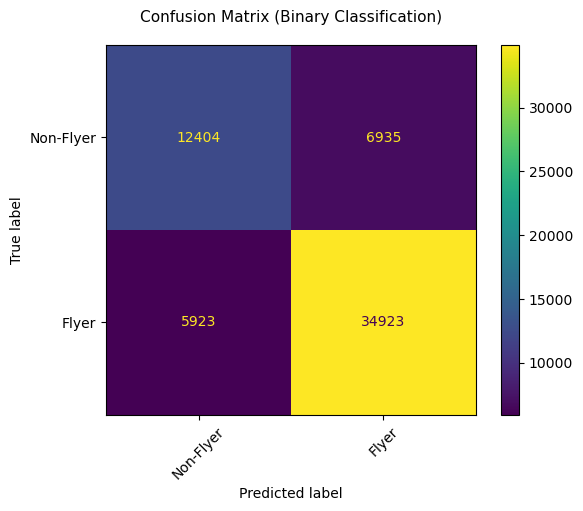

In [20]:
report.plot_confusion_matrix_binary()

##### ROC curve (Multi-class)

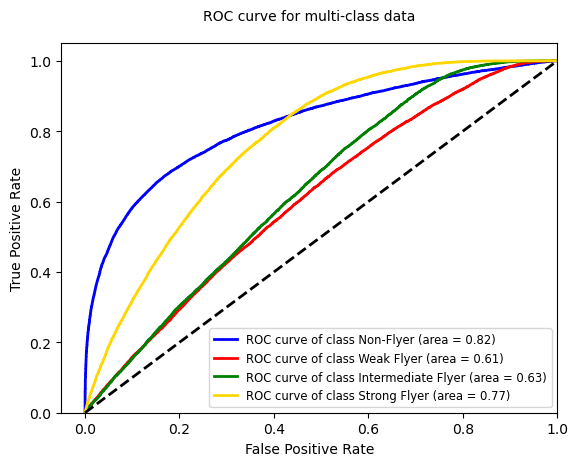

In [21]:
report.plot_roc_curve()

##### Confusion matrix (Multi-class)

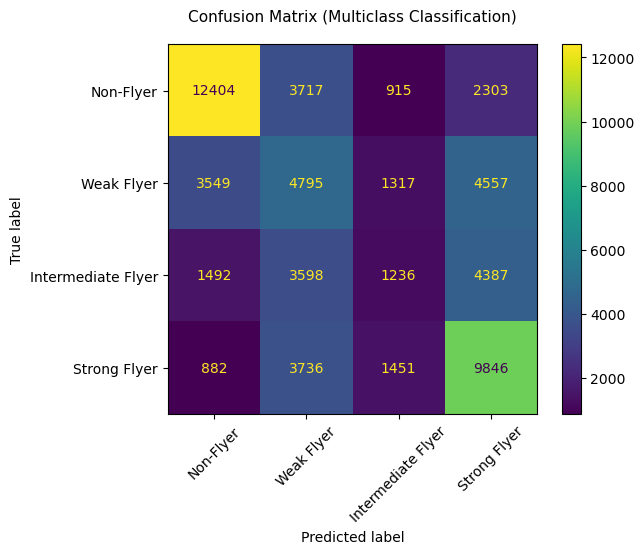

In [22]:
report.plot_confusion_matrix_multiclass()

#### Heatmap of Average Error Between Actual and Predicted Classes

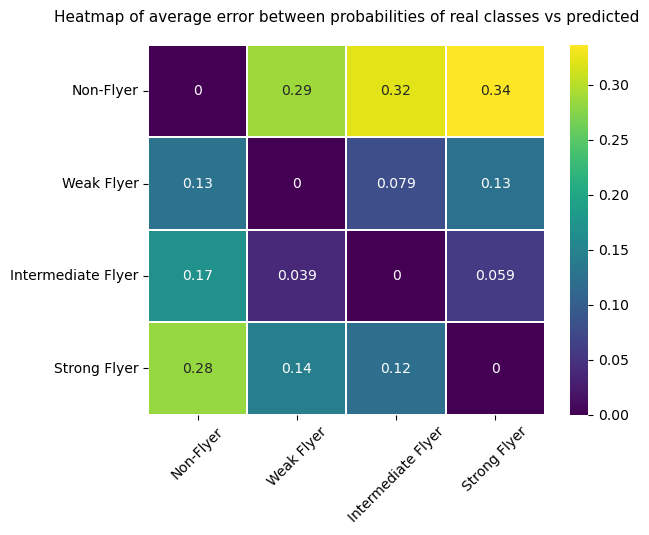

In [23]:
report.plot_heatmap_prediction_prob_error()

We can also produce a complete evaluation report with all the relevant plots in one PDF file by calling the `generate_report` function.

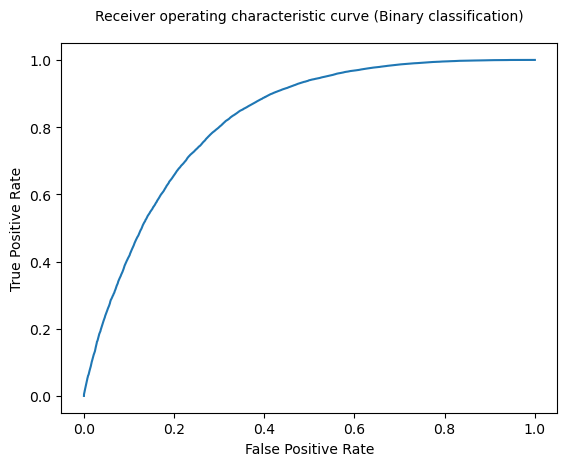

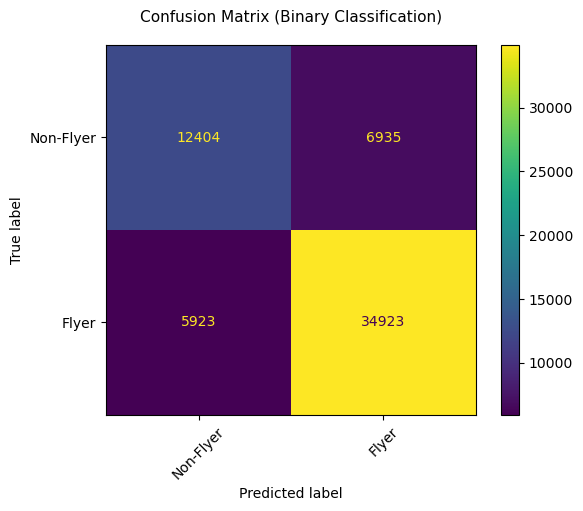

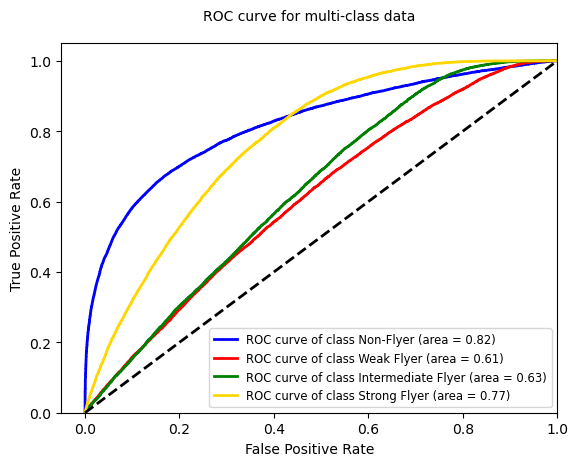

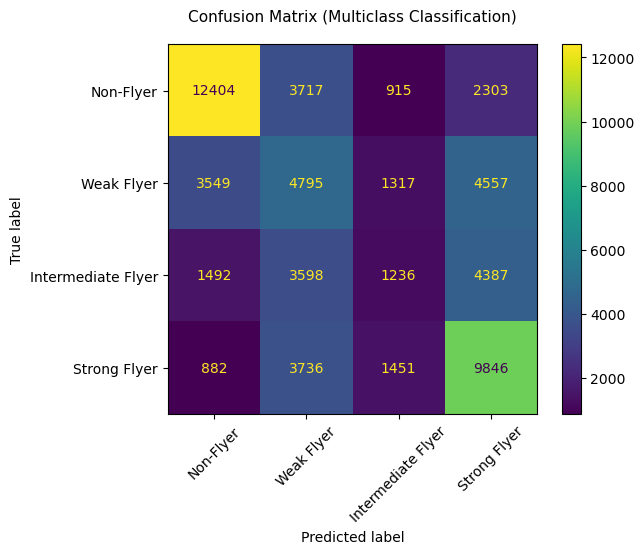

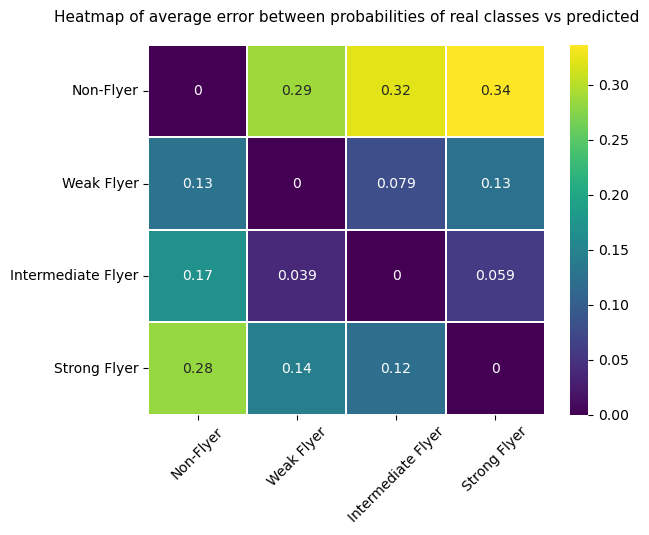

In [24]:
report.generate_report()

# Unlabeled Data

## 1. Load data

For predicting on unlabeled data, follow the same workflow as described earlier (refer to the "Load Data" section for labeled data). Specifically, create an instance of the `DetectabilityDataset` class using your unlabeled data.The configuration below ensures that the entire dataset is treated as test data without generating additional splits (i.e., training and validation sets).

In [25]:
# Sinitcyn_test_unlabeled_data = '../example_dataset/Sinitcyn_test_data_unlabeled.csv'
# Wang_test_unlabeled_data = '../example_dataset/Wang_test_dataset_unlabeled.csv'

Sinitcyn_test_unlabeled_data = 'Sinitcyn_test_dataset_unlabeled.csv'
Wang_test_unlabeled_data = 'Wang_test_dataset_unlabeled.csv'

max_pep_length = 40
BATCH_SIZE = 128
       
test_data_unlabeled = DetectabilityDataset(data_source=None,
                                           val_data_source=None,
                                           test_data_source=Sinitcyn_test_unlabeled_data,
                                           data_format='csv',
                                           max_seq_len=max_pep_length,
                                           label_column='Classes',
                                           sequence_column="Sequences",
                                           dataset_columns_to_keep=['Proteins'],
                                           batch_size=BATCH_SIZE,
                                           with_termini=False,
                                           alphabet=aa_to_int_dict,
                                           auto_cleanup_cache=False)

Generating test split: 60185 examples [00:00, 751891.94 examples/s]
C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\dlomix\data\dataset.py:380: UserWarning: Encoding scheme is unmod, this enforces removing all occurences of PTMs in the sequences.
If you prefer to encode the (amino-acids)+PTM combinations as tokens in the vocabulary, please use the encoding scheme 'naive-mods'.

  warnings.warn(


Applying step: SequenceParsingProcessor on split test...


Mapping SequenceParsingProcessor: 100%|██████████| 60185/60185 [00:00<00:00, 94913.81 examples/s] 


Applying step: SequencePTMRemovalProcessor on split test...


Mapping SequencePTMRemovalProcessor: 100%|██████████| 60185/60185 [00:01<00:00, 51512.59 examples/s]


Applying step: SequenceEncodingProcessor on split test...


Mapping SequenceEncodingProcessor: 100%|██████████| 60185/60185 [00:01<00:00, 47654.38 examples/s]


Applying step: SequencePaddingProcessor on split test...


Mapping SequencePaddingProcessor: 100%|██████████| 60185/60185 [00:00<00:00, 62532.56 examples/s]


In [26]:
test_data_unlabeled

DatasetDict({
    test: Dataset({
        features: ['Sequences', 'Classes', 'Proteins', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 60185
    })
})

## 2. Predicting and reporting

We use the previously loaded model to generate predictions on the dataset. If labels are not available, you can utilize the `predictions_report` function to produce a clear and organized report based on these predictions. Note that the `predictions_report` function is specifically designed for scenarios where labels are not present.

##### Generate Predictions on Test Data Using `model.predict`

To obtain predictions for your test data, use the Keras `model.predict` method. Simply pass your test dataset to this method, and it will return the model's predictions.

In [27]:
predictions_unlabeled = model.predict(test_data_unlabeled.tensor_test_data)

C:\Users\JZ05DL\anaconda3\envs\tf\lib\site-packages\datasets\arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


471/471 [==============================] - 6s 7ms/step


To generate reports we obtain the data for the specific dataset split. This can be achieved using the `DetectabilityDataset` class directly.

In [28]:
# The dataframe needed for the report

test_data_unlabeled_df = pd.DataFrame(
    {
        "Sequences": test_data_unlabeled["test"]["_parsed_sequence"], # get the raw parsed sequences
        "Proteins": test_data_unlabeled["test"]["Proteins"] # get the Proteins column from the dataset object
    }
)

test_data_unlabeled_df.Sequences = test_data_unlabeled_df.Sequences.apply(lambda x: "".join(x)) # join the sequences since they are a list of string amino acids.
test_data_unlabeled_df.head(5)

,Sequences,Proteins
0,TNQLEAINAALLGEDCFILMPTGGGK,P54132
1,QAYTSAPMVDNELLR,Q5T200
2,LTVENIGYQMLMK,Q8IWZ8
3,NFLFRPTSANMLQHPFVR,Q7Z2Y5
4,ICLDNDER,Q03188


#### Generate a report using the `predictions_report` class by providing the following parameters:

- **predictions**: The model's output predictions for the dataset.
- **input_data_df**: The DataFrame containing the input data used for generating the predictions.
- **output_path**: The path where the generated report (in CSV format) will be saved.
- **rank_by_prot**: A boolean indicating whether to rank peptides based on their associated proteins (`True` or `False`). Defaults to `False`.
- **threshold**: The classification threshold used to adjust the decision boundary for predictions. By default, this is set to `None`, meaning no specific threshold is applied.

The `predictions_report` class processes the model’s predictions and generates a comprehensive CSV report with the results, including any specified settings, which facilitates evaluation and interpretation of the predictions.

In [29]:
new_predictions_report = predictions_report(predictions = predictions_unlabeled, 
                                            input_data_df = test_data_unlabeled_df, 
                                            output_path = "./output/report_on_Sinitcyn_2000_proteins_test_set_unlabeled", 
                                            rank_by_prot = True,
                                            threshold = None)

In [30]:
results_unlabeled_df = new_predictions_report.predictions_report
results_unlabeled_df

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Predictions,Binary Predictions,Rank
0,ILFLVAAATGAHSQVQLVQSGSELK,A0A0J9YVY3,0.301,0.295,0.261,0.143,0.857,Weak Flyer,Flyer,1
1,ASGYTFTSYAMNWVR,A0A0J9YVY3,0.307,0.214,0.206,0.274,0.727,Weak Flyer,Flyer,2
2,QAPGQGLEWMGWINTNTGNPTYAQGFTGR,A0A0J9YVY3,0.253,0.173,0.146,0.428,0.572,Non-Flyer,Non-Flyer,3
3,FVFSLDTSVSTAYLQICSLK,A0A0J9YVY3,0.174,0.038,0.001,0.786,0.213,Non-Flyer,Non-Flyer,4
4,KPGASVK,A0A0J9YVY3,0.004,0.000,0.000,0.996,0.004,Non-Flyer,Non-Flyer,5
...,...,...,...,...,...,...,...,...,...,...
60180,QLWMPFSVFDSLNLEEIYNSVQPDPESVVLGTDGGR,Q9Y6Y8,0.161,0.025,0.001,0.813,0.187,Non-Flyer,Non-Flyer,35
60181,AVAATSTK,Q9Y6Y8,0.104,0.027,0.003,0.866,0.134,Non-Flyer,Non-Flyer,36
60182,IDYVLQEKPIESFNEYLFALQSHLCYWESEDTALLLLK,Q9Y6Y8,0.067,0.009,0.000,0.924,0.076,Non-Flyer,Non-Flyer,37
60183,GQEQSAQK,Q9Y6Y8,0.030,0.002,0.000,0.968,0.032,Non-Flyer,Non-Flyer,38
